In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

from copy import deepcopy as copy
# np.random.seed(1)

In [2]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-ts_33os6
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-ts_33os6
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=d7e9e6b6eb2a972e3ddf4120f4bd6878cf8b7b8f95b515c4e42b9950668114bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-34osvfr3/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [3]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-8fp538j_
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-8fp538j_
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=8255b43e3c6fa4caca513b3b23fd6306b2d0384bffa5675d5136ad7376ef4c26
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmr74805/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate
  Attempting uninstall: pyTorchTemplate
    Found existing installation: pyTorchTemplate 0.0.1
    Uninstalling pyTorchTemplate-0.0.1:
      Successfully uninstalled pyTorchTemplate-0.0.1


In [4]:
import torch
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyTorchTemplate as ptt

$$
\begin{eqnarray}
\boldsymbol{R} &=& |\boldsymbol{x}| \\
{f} &=& \frac{\sin(4\pi \boldsymbol{R})}{4\pi\boldsymbol{R}}
\end{eqnarray}
$$

In [5]:
ndim = 12
nSample = 2048
p = 4

In [6]:
def f(x):
    """The function to predict."""
    
    R = np.sqrt(np.sum(x**2,axis=1)) + 0.0001
    return np.sin(4*np.pi*R)/(4*np.pi*R)

# Prepare data

In [7]:
x_train = ((np.random.rand(nSample,ndim)-0.5)*2).astype(np.float32)
y_train = f(x_train).reshape(-1,1).astype(np.float32)

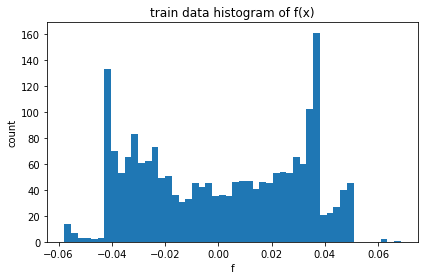

In [8]:
plt.hist(y_train,bins=50);
plt.xlabel('f')
plt.ylabel('count')
plt.title('train data histogram of f(x)')
plt.tight_layout()
plt.savefig('train_data_histo_'+str(ndim)+'D_'+str(nSample)+'sample.png',dpi=180)

In [9]:
x_test = ((np.random.rand(65536,ndim)-0.5)*2).astype(np.float32)
y_test = f(x_test).reshape(-1,1).astype(np.float32)

In [10]:
x_onAxis = np.zeros([256,ndim]).astype(np.float32)
x_onAxis[:,0] = np.linspace(-1, 1, 256)
y_onAxis = f(x_onAxis).reshape(-1,1).astype(np.float32)

In [11]:
train_data_loader = torch.utils.data.DataLoader(list(zip(x_train,y_train)),batch_size=128)
test_data_loader = torch.utils.data.DataLoader(list(zip(x_test,y_test)),batch_size=128)

### GP w/o dim-reduction

In [12]:
kernel = C(0.2, (2e-2, 1e1)) * RBF(1, (2e-2, 1e1))
gpNaive = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [13]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)

(-0.0011121784492225115, -3.974310453402907e-06)

In [14]:
gpNaive.fit(x_train, y_train)
gpNaive.kernel_

0.141**2 * RBF(length_scale=1.29)

In [15]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)   #(0.9999999999999998, 0.2938582961152787)

(0.9999999999999831, -1.4844158868670072)

In [16]:
y_onAxis_GPnaive, sigma_GPnaive = gpNaive.predict(x_onAxis, return_std=True)
y_onAxis_GPnaive = y_onAxis_GPnaive.reshape(-1)

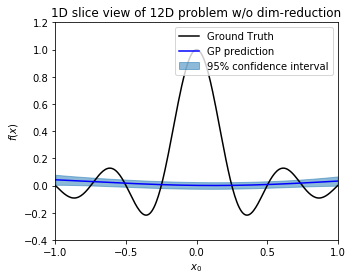

In [17]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GPnaive, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GPnaive- 1.96 * sigma_GPnaive,
                y_onAxis_GPnaive+ 1.96 * sigma_GPnaive, 
                label='95% confidence interval', color='C0', alpha=.5, )
# plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w/o dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_woDimReduct_'+str(ndim)+'D.png',dpi=180)

# with DimReduction

### AutoEncoderLike NN

In [18]:
def test(model,criterion,test_data_loader):
  model.eval()
  loss = 0 
  for x, y in test_data_loader:
    x = x.to(device)
    y_pred = model(x)
    loss += criterion(y_pred, y.to(device)).item()
  return loss/len(test_data_loader)

### 4D source

In [19]:
nsource = 4

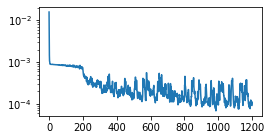

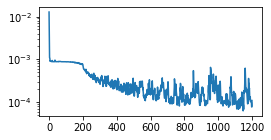

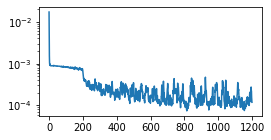

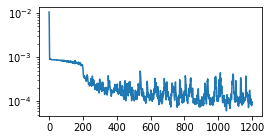

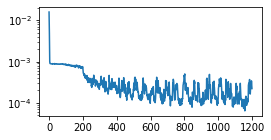

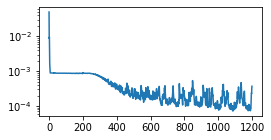

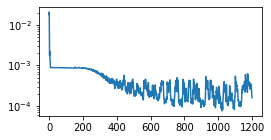

In [20]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,128,128,nsource],[nsource,32,32,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 4e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

6.314527195172559e-05


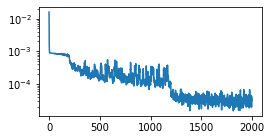

In [21]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
print(newloss)

In [22]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.0113827 ],
       [-0.00354574],
       [-0.01674376],
       [ 0.02125887],
       [-0.02724569],
       [-0.0213738 ],
       [-0.01310647],
       [ 0.02359686],
       [ 0.03491796],
       [-0.04240518]], dtype=float32)

In [23]:
f(x_train[:10,:])

array([ 0.0129979 , -0.00257394, -0.01686266,  0.02381356, -0.02570891,
       -0.02056983, -0.01225886,  0.02634715,  0.03708243, -0.0424777 ],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [24]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[-103.29493] [310.27722]
[-103.29493, -28.542805] [310.27722, 86.97822]
[-103.29493, -28.542805, -193.55643] [310.27722, 86.97822, 492.9414]
[-103.29493, -28.542805, -193.55643, -95.629074] [310.27722, 86.97822, 492.9414, 1025.9988]


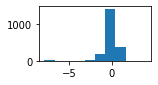

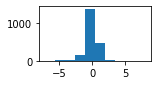

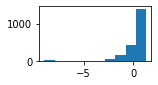

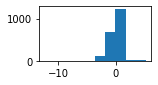

In [25]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [26]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

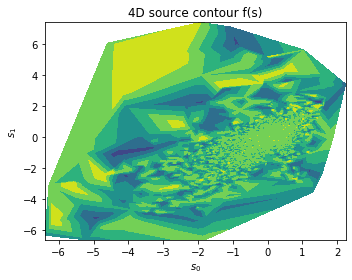

In [27]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [28]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [29]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [30]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0011121784492225115, -3.974310453402907e-06)

In [31]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=8.44)

In [32]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.7055563241024517, -0.1370224368969688)

##### on axis

In [33]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [34]:
y_onAxis_NN.shape

(256, 1)

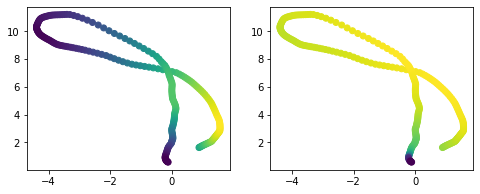

In [35]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_GP)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_NN[:,0])

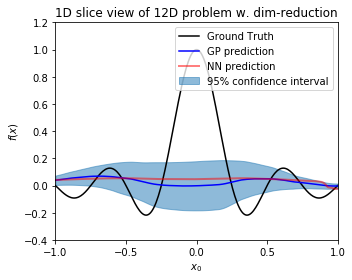

In [36]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [37]:
ptt.count_parameters(model)

194061

### 3D source

In [38]:
nsource = 3

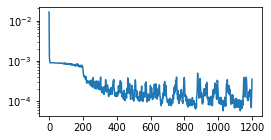

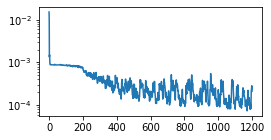

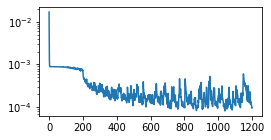

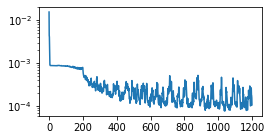

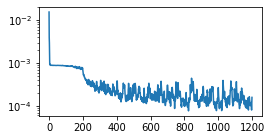

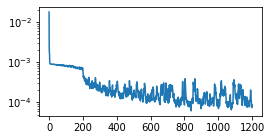

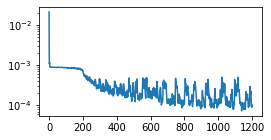

In [39]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,128,128,nsource],[nsource,32,32,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 4e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

3.1565794984089734e-05


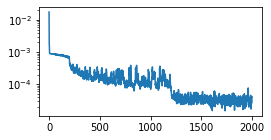

In [40]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [41]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.01237215],
       [-0.00378898],
       [-0.01413753],
       [ 0.02337674],
       [-0.02697061],
       [-0.02100387],
       [-0.01320334],
       [ 0.02540617],
       [ 0.03641645],
       [-0.04324308]], dtype=float32)

In [42]:
f(x_train[:10,:])

array([ 0.0129979 , -0.00257394, -0.01686266,  0.02381356, -0.02570891,
       -0.02056983, -0.01225886,  0.02634715,  0.03708243, -0.0424777 ],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [43]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[12.452082] [39.95317]
[12.452082, 764.79535] [39.95317, 1519.0968]
[12.452082, 764.79535, -57.54789] [39.95317, 1519.0968, 113.073296]


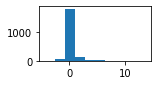

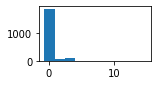

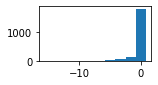

In [44]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [45]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

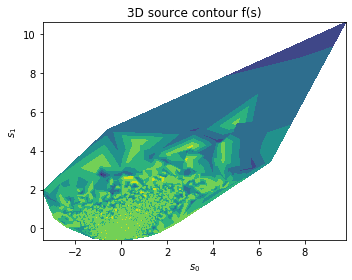

In [46]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [47]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [48]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [49]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0011121784492225115, -3.974310453402907e-06)

In [50]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=6.73)

In [51]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.5780386342201675, -0.16471691576106595)

##### on axis

In [52]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [53]:
y_onAxis_NN.shape

(256, 1)

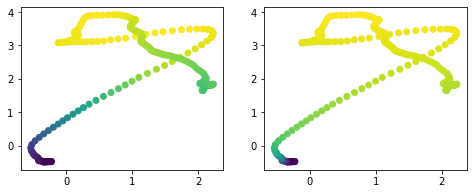

In [54]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_GP)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_NN[:,0])

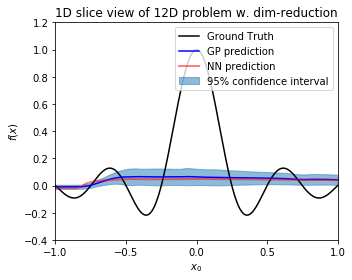

In [55]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [56]:
ptt.count_parameters(model)

193882

### 2D source

In [57]:
nsource = 2

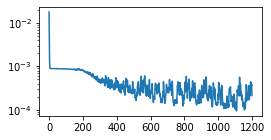

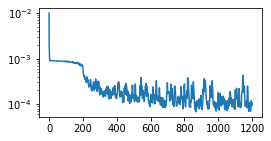

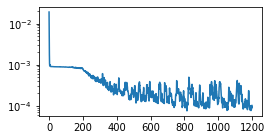

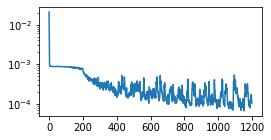

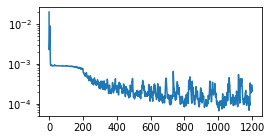

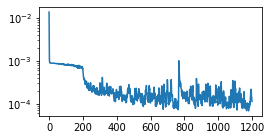

In [58]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,128,128,nsource],[nsource,32,32,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 4e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

4.338344137977401e-05


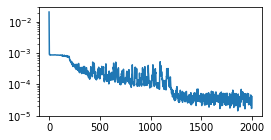

In [59]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [60]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.01124238],
       [-0.00349531],
       [-0.01688816],
       [ 0.0217798 ],
       [-0.02554833],
       [-0.01985116],
       [-0.0124626 ],
       [ 0.02403535],
       [ 0.0348977 ],
       [-0.04139709]], dtype=float32)

In [61]:
f(x_train[:10,:])

array([ 0.0129979 , -0.00257394, -0.01686266,  0.02381356, -0.02570891,
       -0.02056983, -0.01225886,  0.02634715,  0.03708243, -0.0424777 ],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [62]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[21.706419] [70.43321]
[21.706419, 232.33557] [70.43321, 476.5563]


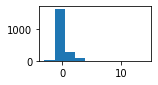

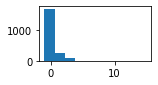

In [63]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [64]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

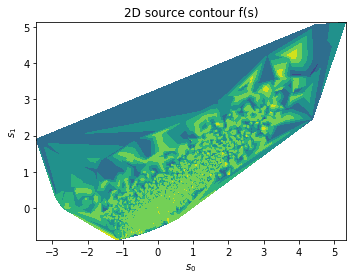

In [65]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [66]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [67]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [68]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0011121784492225115, -3.974310453402907e-06)

In [69]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=4.09)

In [70]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.7265531578237383, -0.26260754202831715)

##### on axis

In [71]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [72]:
y_onAxis_NN.shape

(256, 1)

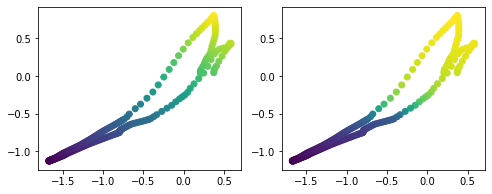

In [73]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_GP)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_NN[:,0])

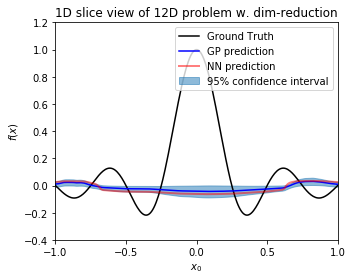

In [74]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [75]:
ptt.count_parameters(model)

193632

### 1D source

In [76]:
nsource = 1

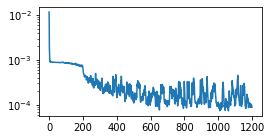

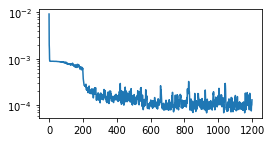

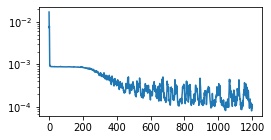

In [77]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,128,128,nsource],[nsource,32,32,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 4e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

5.472256771099637e-05


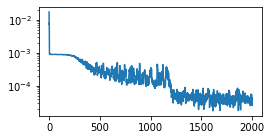

In [78]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [79]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.01444919],
       [-0.0025949 ],
       [-0.0172179 ],
       [ 0.0260999 ],
       [-0.02747574],
       [-0.02218718],
       [-0.0124183 ],
       [ 0.02834261],
       [ 0.03885702],
       [-0.04432353]], dtype=float32)

In [80]:
f(x_train[:10,:])

array([ 0.0129979 , -0.00257394, -0.01686266,  0.02381356, -0.02570891,
       -0.02056983, -0.01225886,  0.02634715,  0.03708243, -0.0424777 ],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [81]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[28.818567] [91.93865]


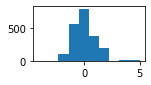

In [82]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [83]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

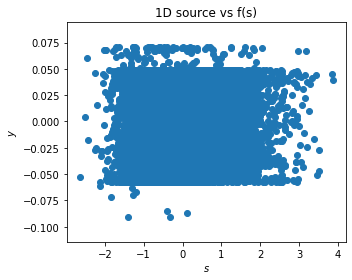

In [84]:
plt.figure(figsize=(5,4))
plt.scatter(s_test[:,0],y_test.reshape(-1))

plt.title(str(nsource)+'D source vs f(s)')
plt.xlabel(r'$s$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.savefig('4Dto1D_source_contour.png',dpi=180)

In [85]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [86]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [87]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0011121784492225115, -3.974310453402907e-06)

In [88]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=3.86)

In [89]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.9357588400935004, -0.32976797412455655)

##### on axis

In [90]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [91]:
y_onAxis_NN.shape

(256, 1)

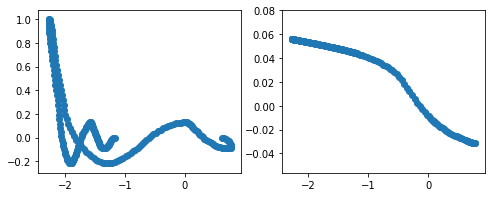

In [92]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],y_onAxis)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],y_onAxis_NN)

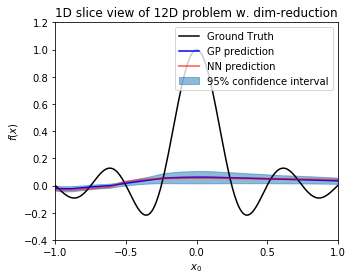

In [93]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [94]:
ptt.count_parameters(model)

193454